# **강화학습 중간고사 시험 문제**
- 코드의 단계별로 작성하고 설명 작성하세요.
- 각각의 ipynb 파일로 제출하세요.
- 파일명 예시: **202500000 홍길동_Grid world.ipynb**

# 학번과 이름을 기입해주세요. (한글)

- 학번: 202192022
- 이름: 여명구

## **1. Grid World**

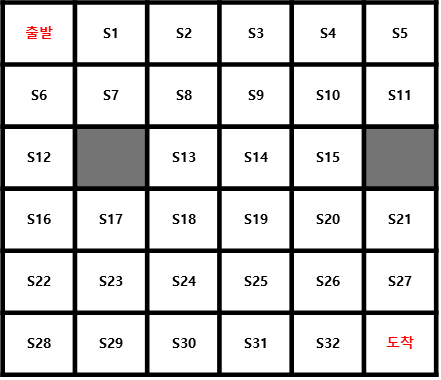

- 회색 부분: 벽(이동 불가)
- 정책: 상하좌우 이동
- γ= 1
- **제출 내용**
  1)  정책의 상태가치함수(각 상태별)
  2)  최대 보상의 최적 경로

S19, S25는 빙판

그리드월드에서 문제를 풀었다고 말할 수 있는 상황은 "최적 정책"을 찾았을 때임.

이는 그리드 월드의 어떤 컨에서 시작하든 목표 지점까지 누적 보상을 최대로 만들 수 있는 완벽한 행동 지침을 확보했다는 뜻임.

===== [최적 경로 탐색 및 시각화 (비용 기반)] =====
가치 반복 수렴 완료! (총 8회 반복)

--- 최적 가치 함수 (V* / 최소 비용) ---
[[-7. -6. -5. -4. -5. -6.]
 [-6. -5. -4. -3. -4. -5.]
 [-6.  0. -3. -2. -3.  0.]
 [-5. -4. -3. -2. -2. -1.]
 [-4. -3. -2. -2. -1.  0.]
 [-4. -3. -2. -1.  0.  0.]]

--- 최적 정책 (Policy*) ---
[[list(['D', 'R']) list(['D', 'R']) list(['D', 'R']) list(['D'])
  list(['D', 'L']) list(['D', 'L'])]
 [list(['R']) list(['R']) list(['D', 'R']) list(['D']) list(['D', 'L'])
  list(['L'])]
 [list(['D']) 'T' list(['R']) list(['D']) list(['D', 'L']) 'T']
 [list(['D', 'R']) list(['D', 'R']) list(['D', 'R']) list(['D'])
  list(['D', 'R']) list(['D'])]
 [list(['R']) list(['R']) list(['R']) list(['D', 'R']) list(['D', 'R'])
  list(['D'])]
 [list(['R']) list(['R']) list(['R']) list(['R']) list(['R']) 'G']]

--- 최적 경로 (Optimal Path) ---
(총 8 스텝)
(0, 0) -> (1, 0) -> (1, 1) -> (1, 2) -> (2, 2) -> (2, 3) -> (5, 3) -> (5, 4) -> (5, 5)

--- 시각화 (GraphicDisplay) ---

--- [1] 최적 정책 수렴 과정 (경로 및 가치 변화) ---

--- 8회 반복 동안의 경로 및 가치

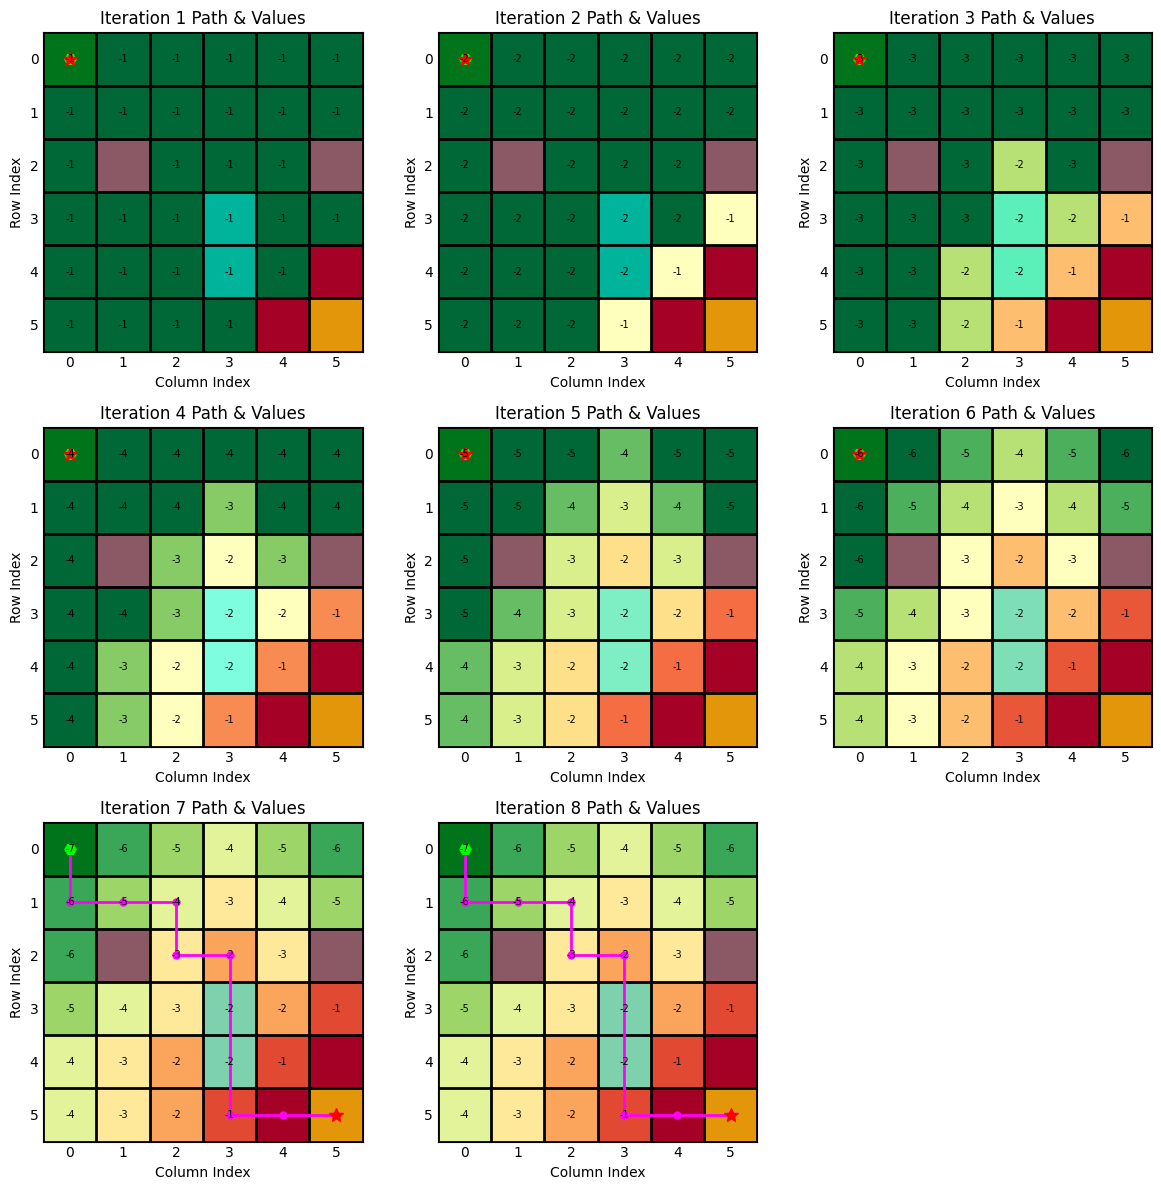


--- [2] 최종 최적 가치(비용) 및 정책 시각화 (오버레이) ---


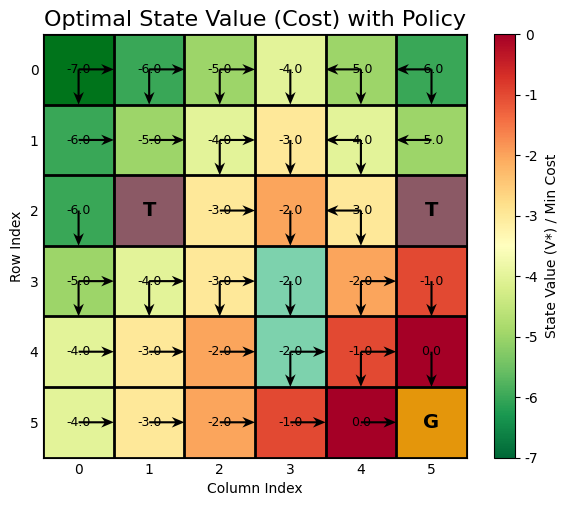


--- [3] 최종 최적 경로 시뮬레이션 시각화 (오버레이) ---


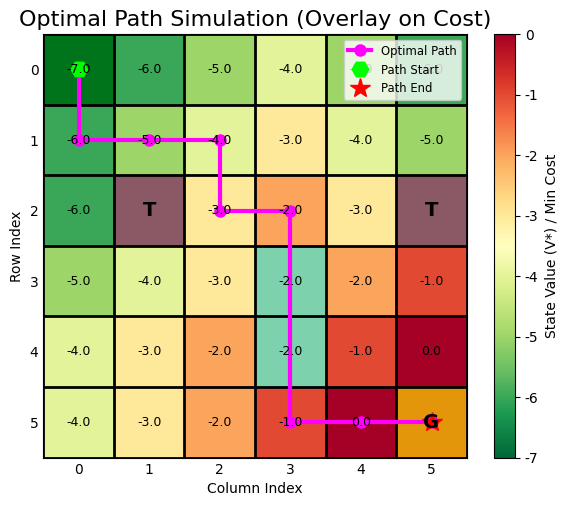

모든 시각화 완료.


In [ ]:
'''
이 코드는 사용자가 정의한 6x6 그리드 월드 환경에서 최적의 정책을 찾기 위한
가치 반복(Value Iteration) 알고즘을 구현합니다.

[환경 규칙]
(이전과 동일)

[알고리즘]
- [수정] extract_policy: np.argmax 대신, np.isclose를 사용하여
  최적 가치와 "동일한" 모든 행동을 리스트로 저장합니다.
  (예: (0,0) -> ['D', 'R'])
- [수정] simulate_optimal_path: 정책이 리스트 형태인 것을
  감안하여, 리스트의 첫 번째 행동을 따라가도록 수정했습니다.

[시각화]
- (이전과 동일, 작은 플롯 사이즈, 비용 기반, 0~5 축)
- [수정] _draw_policy_arrows:
    1. (0,0)처럼 여러 최적 행동이 있는 경우, 모든 화살표를 그립니다.
    2. 화살표 색상: 'black' (검은색)
    3. 화살표 크기: width, headwidth, headlength 축소
    4. 화살표 길이: scale=2로 설정 (기존의 절반 길이)
- [수정] main 실행 순서:
    1. Iteration History (수렴 과정)
    2. Final Value + Policy (최종 정책)
    3. Final Path (최종 경로)
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- 1. 환경 설정 (Constants) ---
# (변경 없음)
GRID_ROWS = 6
GRID_COLS = 6

START_STATE = (0, 0)
GOAL_STATE = (5, 5)
TRAP_STATES = [(2, 1), (2, 5)]
ICE_STATES = [(3, 3), (4, 3)]

ACTIONS = {
    'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)
}
ACTION_NAMES = list(ACTIONS.keys())

GAMMA = 1.0
THETA = 1e-5
MAX_PATH_STEPS = 100

# --- 2. 환경 핵심 로직 (규칙 함수) ---
# (빙판 위 슬라이딩 포함, 변경 없음)
def get_next_state_and_reward(state, action_name): # 현재 상태(s), 행동(a)을 입력으로 받아 다음 상태(s')와 보상(r)을 계산
    if state == GOAL_STATE or state in TRAP_STATES:
        return state, 0
    action_delta = ACTIONS[action_name]
    r, c = state
    dr, dc = action_delta
    next_r, next_c = r + dr, c + dc
    next_state = (next_r, next_c)
    reward = -1 
    if not (0 <= next_r < GRID_ROWS and 0 <= next_c < GRID_COLS):
        return state, reward
    if next_state == GOAL_STATE:
        return next_state, 0 
    if next_state in TRAP_STATES:
        return next_state, -100
    if (next_state in ICE_STATES):
        current_slide_pos = next_state
        while current_slide_pos in ICE_STATES:
            land_r, land_c = current_slide_pos[0] + dr, current_slide_pos[1] + dc
            land_pos = (land_r, land_c)
            if not (0 <= land_r < GRID_ROWS and 0 <= land_c < GRID_COLS):
                return current_slide_pos, reward 
            current_slide_pos = land_pos
        if current_slide_pos == GOAL_STATE:
            return current_slide_pos, 0
        if current_slide_pos in TRAP_STATES:
            return current_slide_pos, -100
        return current_slide_pos, reward
    return next_state, reward

# --- 3. 가치 반복 (Value Iteration) 알고리즘 ---
# (V_history 반환, 변경 없음)
def value_iteration():
    V = np.zeros((GRID_ROWS, GRID_COLS))
    V_history = [] 
    iteration = 0
    while True:
        iteration += 1
        delta = 0
        V_current_iter = np.copy(V)
        for r in range(GRID_ROWS):
            for c in range(GRID_COLS):
                state = (r, c)
                if state == GOAL_STATE or state in TRAP_STATES:
                    continue
                v_old = V_current_iter[state]
                action_values = []
                for action_name in ACTION_NAMES:
                    (next_state, reward) = get_next_state_and_reward(state, action_name)
                    value = reward + GAMMA * V_current_iter[next_state]
                    action_values.append(value)
                V[state] = np.max(action_values)
                delta = max(delta, abs(V[state] - v_old))
        V_history.append(np.copy(V))
        if delta < THETA:
            print(f"가치 반복 수렴 완료! (총 {iteration}회 반복)")
            break
    return V_history

# --- 4. 최적 정책 추출 및 경로 시뮬레이션 ---

# [수정] 모든 최적 행동을 리스트로 저장
def extract_policy(V):
    """
    V*를 바탕으로 모든 최적 행동을 리스트로 저장한 정책을 추출합니다.
    (예: ['D', 'R'])
    """
    # dtype=object여야 리스트를 저장할 수 있음
    Policy = np.full((GRID_ROWS, GRID_COLS), ' ', dtype=object) 
    
    for r in range(GRID_ROWS):
        for c in range(GRID_COLS):
            state = (r, c)
            
            # 터미널 상태는 문자열로 저장 (시뮬레이션 편의)
            if state == GOAL_STATE: 
                Policy[state] = 'G'
                continue
            if state in TRAP_STATES: 
                Policy[state] = 'T'
                continue
                
            # 최적 행동 계산
            action_values = []
            for action_name in ACTION_NAMES:
                (next_state, reward) = get_next_state_and_reward(state, action_name)
                value = reward + GAMMA * V[next_state]
                action_values.append(value)
            
            # [수정] 가장 좋은 가치(best_value)와
            # np.isclose(부동소수점 비교)를 사용하여 동일한 모든 행동을 찾음
            best_value = np.max(action_values)
            best_indices = np.where(np.isclose(action_values, best_value))[0]
            
            # 최적 행동들을 리스트로 저장
            Policy[state] = [ACTION_NAMES[i] for i in best_indices]

    return Policy

# [수정] 정책이 리스트임을 감안하여 경로 시뮬레이션
def simulate_optimal_path(Policy_star):
    """
    추출된 최적 정책(Policy_star)을 따라 경로를 반환합니다.
    최적 행동이 여러 개일 경우, 첫 번째 행동을 따릅니다.
    """
    path = []
    current_state = START_STATE
    path.append(current_state)
    
    for _ in range(MAX_PATH_STEPS):
        if current_state == GOAL_STATE or current_state in TRAP_STATES:
            break
        
        # [수정] Policy_star[state]는 이제 리스트임 (예: ['D', 'R'])
        action_list = Policy_star[current_state]
        
        # 경로 시뮬레이션은 그 중 첫 번째 행동을 선택
        action_name = action_list[0] 
        
        (next_state, reward) = get_next_state_and_reward(current_state, action_name)
        current_state = next_state
        path.append(current_state)
        
    return path

# --- 5. 시각화 클래스 (GraphicDisplay) ---

class GraphicDisplay:
    def __init__(self, grid_rows, grid_cols):
        # (변경 없음)
        self.rows = grid_rows
        self.cols = grid_cols
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
        self.policy_arrows = {
            'U': (0, -1), 'D': (0, 1), 'L': (-1, 0), 'R': (1, 0),
            'G': (0, 0), 'T': (0, 0), ' ': (0, 0)
        }

    def _setup_grid_ax(self, ax, title, fontsize=16):
        # (축 레이블 0~5, 변경 없음)
        ax.set_xticks(np.arange(self.cols))
        ax.set_yticks(np.arange(self.rows))
        ax.set_xticks(np.arange(-.5, self.cols, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.rows, 1), minor=True)
        ax.set_xlabel('Column Index')
        ax.set_ylabel('Row Index')
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        ax.tick_params(which='minor', size=0)
        ax.tick_params(which='major', size=0)
        ax.set_title(title, fontsize=fontsize)

    def _color_special_states(self, ax, show_labels=True):
        # (변경 없음)
        for r, c in TRAP_STATES:
            ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, color='gray', alpha=0.7))
            if show_labels:
                ax.text(c, r, 'T', ha='center', va='center', color='black', fontsize=14, weight='bold')
        for r, c in ICE_STATES:
            ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, color='cyan', alpha=0.5))
        r_g, c_g = GOAL_STATE
        ax.add_patch(plt.Rectangle((c_g - 0.5, r_g - 0.5), 1, 1, color='gold', alpha=0.7))
        if show_labels:
            ax.text(c_g, r_g, 'G', ha='center', va='center', color='black', fontsize=14, weight='bold')
        r_s, c_s = START_STATE
        ax.add_patch(plt.Rectangle((c_s - 0.5, r_s - 0.5), 1, 1, color='green', alpha=0.5))

    # [수정] 모든 최적 행동 화살표를 작고 검게 (절반 길이) 그림
    def _draw_policy_arrows(self, ax, Policy):
        """정책 화살표를 작고 검은색으로 (절반 길이) 그립니다."""
        
        for r in range(self.rows):
            for c in range(self.cols):
                state = (r, c)
                action_list_or_str = Policy[state]
                
                # 터미널 상태('G', 'T')나 공백(' ')은 건너뜀
                if isinstance(action_list_or_str, str):
                    continue
                
                # 이제 action_list_or_str는 ['D', 'R'] 같은 리스트임
                for action_name in action_list_or_str:
                    dx, dy = self.policy_arrows[action_name]
                    
                    # [수정] ax.quiver를 셀마다, 행동마다 호출
                    ax.quiver(c, r, dx, dy, # (x, y, dx, dy)
                              scale=2,      # [요청] scale=2 (절반 길이)
                              scale_units='xy', angles='xy',
                              color='black',    # [요청] 색상: black
                              width=0.005,    # [요청] 두께 (축소)
                              headwidth=5,    # [요청] 머리 너비 (축소)
                              headlength=6)   # [요청] 머리 길이 (축소)
    # -----------------------------------------------------

    def show_values_and_policy(self, V, Policy):
        # (figsize 축소, cmap 수정, 변경 없음)
        fig, ax = plt.subplots(figsize=(7, 5.5)) 
        v_min, v_max = V.min(), 0
        if v_min >= v_max: v_min = v_max - 1e-9
        norm = mcolors.TwoSlopeNorm(vcenter=(v_min/2), vmin=v_min, vmax=v_max)
        im = ax.imshow(V, cmap='RdYlGn_r', norm=norm) 
        fig.colorbar(im, ax=ax, label='State Value (V*) / Min Cost')
        self._color_special_states(ax, show_labels=True)
        for r in range(self.rows):
            for c in range(self.cols):
                state = (r, c)
                if state == GOAL_STATE or state in TRAP_STATES:
                    continue
                ax.text(c, r, f"{V[r, c]:.1f}", 
                        ha='center', va='center', color='black', fontsize=9)
        self._draw_policy_arrows(ax, Policy) # 수정된 스타일이 적용됨
        self._setup_grid_ax(ax, 'Optimal State Value (Cost) with Policy')
        plt.show()

    def show_optimal_path_overlay(self, V, path):
        # (figsize 축소, cmap 수정, 변경 없음)
        fig, ax = plt.subplots(figsize=(7, 5.5)) 
        v_min, v_max = V.min(), 0
        if v_min >= v_max: v_min = v_max - 1e-9
        norm = mcolors.TwoSlopeNorm(vcenter=(v_min/2), vmin=v_min, vmax=v_max)
        im = ax.imshow(V, cmap='RdYlGn_r', norm=norm)
        fig.colorbar(im, ax=ax, label='State Value (V*) / Min Cost')
        self._color_special_states(ax, show_labels=True)
        for r in range(self.rows):
            for c in range(self.cols):
                state = (r, c)
                if state == GOAL_STATE or state in TRAP_STATES:
                    continue 
                ax.text(c, r, f"{V[r, c]:.1f}", 
                        ha='center', va='center', color='black', fontsize=9)
        if not path:
            print("경로가 없습니다.")
            return
        path_cols = [state[1] for state in path]
        path_rows = [state[0] for state in path]
        ax.plot(path_cols, path_rows, color='magenta', marker='o',
                linewidth=3, markersize=8, label='Optimal Path')
        ax.plot(path_cols[0], path_rows[0], marker='H', markersize=12, 
                color='lime', linestyle='None', label='Path Start')
        ax.plot(path_cols[-1], path_rows[-1], marker='*', markersize=15, 
                color='red', linestyle='None', label='Path End')
        self._setup_grid_ax(ax, 'Optimal Path Simulation (Overlay on Cost)')
        ax.legend(fontsize='small')
        plt.show()
        
    def show_path_iteration_history(self, V_history):
        # (3x3 플롯에 가치 텍스트 표시, 변경 없음)
        num_iterations = len(V_history)
        num_cols = 3
        num_rows = int(np.ceil(num_iterations / num_cols))
        fig, axes = plt.subplots(num_rows, num_cols, 
                                 figsize=(num_cols * 4, num_rows * 4))
        axes_flat = axes.flat if num_iterations > 1 else [axes]
        
        print(f"\n--- {num_iterations}회 반복 동안의 경로 및 가치 변화 시각화 ---")

        for i in range(num_iterations):
            ax = axes_flat[i]
            V_iter = V_history[i]
            # [수정] 경로 플롯을 위해 extract_policy 호출
            Policy_iter = extract_policy(V_iter) 
            path_iter = simulate_optimal_path(Policy_iter)
            
            v_min, v_max = V_iter.min(), 0
            if v_min >= v_max: v_min = v_max - 1e-9
            norm_iter = mcolors.TwoSlopeNorm(vcenter=(v_min/2), vmin=v_min, vmax=v_max)
            ax.imshow(V_iter, cmap='RdYlGn_r', norm=norm_iter)
            
            self._color_special_states(ax, show_labels=False)
            
            for r in range(self.rows):
                for c in range(self.cols):
                    state = (r, c)
                    val = V_iter[r, c]
                    if state == GOAL_STATE or state in TRAP_STATES:
                        continue
                    if val != 0: 
                        ax.text(c, r, f"{val:.0f}", 
                                ha='center', va='center', color='black', fontsize=7)
            
            if path_iter:
                path_cols = [state[1] for state in path_iter]
                path_rows = [state[0] for state in path_iter]
                ax.plot(path_cols, path_rows, color='magenta', marker='o', 
                        linewidth=2, markersize=5)
                ax.plot(path_cols[0], path_rows[0], marker='H', 
                        markersize=8, color='lime', ls='None')
                ax.plot(path_cols[-1], path_rows[-1], marker='*', 
                        markersize=10, color='red', ls='None')
            
            self._setup_grid_ax(ax, f'Iteration {i + 1} Path & Values', fontsize=12)
        
        for i in range(num_iterations, len(axes_flat)):
            axes_flat[i].set_visible(False)
            
        plt.tight_layout()
        plt.show()

# --- 6. 메인 실행 ---
if __name__ == "__main__":
    
    print("===== [최적 경로 탐색 및 시각화 (비용 기반)] =====")
    
    V_history = value_iteration()
    V_star = V_history[-1] 
    
    Policy_star = extract_policy(V_star)
    optimal_path = simulate_optimal_path(Policy_star)
    
    print("\n--- 최적 가치 함수 (V* / 최소 비용) ---")
    np.set_printoptions(precision=2, suppress=True)
    print(V_star)
    
    print("\n--- 최적 정책 (Policy*) ---")
    # 정책이 리스트로 출력되어도 놀라지 마세요 (예: (0,0) -> ['D', 'R'])
    print(Policy_star) 
    
    print("\n--- 최적 경로 (Optimal Path) ---")
    print(f"(총 {len(optimal_path) - 1} 스텝)")
    print(" -> ".join(map(str, optimal_path)))

    print("\n--- 시각화 (GraphicDisplay) ---")
    display = GraphicDisplay(GRID_ROWS, GRID_COLS)
    
    # --- [수정된 플롯 순서] ---
    
    # 1. (먼저) 수렴 과정 시각화
    print("\n--- [1] 최적 정책 수렴 과정 (경로 및 가치 변화) ---")
    display.show_path_iteration_history(V_history)
    
    # 2. (다음) 최종 가치 + 정책
    print("\n--- [2] 최종 최적 가치(비용) 및 정책 시각화 (오버레이) ---")
    display.show_values_and_policy(V_star, Policy_star)
    
    # 3. (마지막) 최종 경로
    print("\n--- [3] 최종 최적 경로 시뮬레이션 시각화 (오버레이) ---")
    display.show_optimal_path_overlay(V_star, optimal_path)
    # -------------------------
    
    print("모든 시각화 완료.")

In [14]:
ACTION_NAMES

['U', 'D', 'L', 'R']